In [1]:
import os
import sys
import copy
import random
import json
from tqdm import tqdm, trange

In [2]:
import numpy as np
import cv2
import albumentations as alb

In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
work_path = '/home/user3/work/data/by_z_regression/minsk_t/6/known_dataset'

## Load dataset

In [6]:
def get_image_level(image_path, mask_path, size=(256, 256), aug=None, pad=48, border=128):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)[:,:,0]
    h, w = mask.shape

    levels = np.max(mask)
    if aug:
        sample = aug(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
    
    half_size = int(mask.shape[0] / 2)
    sh, sw = half_size, None
    for i in range(mask.shape[1]):
        v = mask[half_size, i]
        if v != 0:
            sw = i
            break
    if sw is None:
        raise ValueError('Object box not found')
    
    h1, h2 = int(sh - size[0] / 2), int(sh + size[0] / 2)
    w1, w2 = int(sw - size[1] / 2), int(sw + size[1] / 2)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (border, border))
    image_mask = mask.copy()
    image_mask = cv2.dilate(image_mask, kernel, iterations=1).clip(0, 1)
    image = image * np.stack([image_mask, image_mask, image_mask], axis=-1)

    mask = mask[h1:h2, w1:w2]
    
    result = image.copy()[h1:h2, w1:w2, :]
    return result, levels

In [7]:
image_prefix = 'i_'
mask_prefix = 'm_'

# Let's fileter data
min_level = 1
max_level = 256

dataset_files = []
dataset_name = work_path.split('_')[-1]
dataset_items = [fn[len(mask_prefix): ] for fn in os.listdir(work_path) if os.path.isfile(os.path.join(work_path, fn)) and fn.startswith(mask_prefix)]
for n in trange(len(dataset_items)):
    dataset_item = dataset_items[n]
    ip, mp = (os.path.join(work_path, image_prefix + dataset_item), os.path.join(work_path, mask_prefix + dataset_item))
    
    try:
        i, l = get_image_level(ip, mp)
        l = float(l)
        if l < min_level:
            print('Skipped with level < min level', ip)
            continue
        if l > max_level:
            print('Skipped with level > max level', ip)
            continue
        if i.shape[0] != 256 or i.shape[1] != 256:
            print('Skipped with shape != 256', ip)
            continue
    except Exception as e:
        continue

    dataset_files.append((ip, mp, dataset_name, int(l)))

print('Done', len(dataset_files))

  2%|▉                                        | 41/1718 [00:02<01:23, 19.99it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_11716-12110-0-321-5.tif


  4%|█▊                                       | 76/1718 [00:04<01:46, 15.47it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_11545-11921-0-355-8.tif


  5%|██▏                                      | 91/1718 [00:05<01:21, 20.06it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_13769-14161-0-272-4.tif


  6%|██▌                                     | 108/1718 [00:05<01:14, 21.72it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_13356-13693-0-168-4.tif


  8%|███▏                                    | 138/1718 [00:07<01:28, 17.80it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_18519-18872-0-253-1.tif


 11%|████▎                                   | 185/1718 [00:09<01:08, 22.45it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_13415-13824-0-211-9.tif


 11%|████▌                                   | 194/1718 [00:10<01:08, 22.17it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_6093-6453-0-289-1.tif


 14%|█████▍                                  | 236/1718 [00:12<01:17, 19.13it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_12232-12713-0-297-5.tif


 16%|██████▎                                 | 273/1718 [00:14<01:06, 21.60it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_18543-18954-0-285-1.tif


 18%|███████▍                                | 317/1718 [00:16<01:07, 20.62it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_11142-11490-0-195-5.tif


 23%|█████████▎                              | 400/1718 [00:21<00:58, 22.45it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_13705-14058-0-174-2.tif


 24%|█████████▋                              | 415/1718 [00:22<01:02, 20.71it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_12933-13322-0-307-8.tif


 26%|██████████▍                             | 446/1718 [00:23<01:18, 16.22it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_5920-6339-0-235-2.tif


 27%|██████████▊                             | 467/1718 [00:25<01:06, 18.82it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_11406-11754-0-204-5.tif


 29%|███████████▌                            | 497/1718 [00:26<00:59, 20.55it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_11541-12008-0-221-5.tif


 31%|████████████▌                           | 540/1718 [00:28<00:57, 20.41it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_9745-10164-15209-15485-5.tif


 32%|████████████▊                           | 549/1718 [00:29<01:21, 14.36it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_12427-12830-0-239-5.tif


 33%|█████████████▏                          | 564/1718 [00:30<00:55, 20.90it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_244-602-0-252-2.tif
Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_11220-11688-0-253-5.tif


 36%|██████████████▌                         | 625/1718 [00:33<00:53, 20.61it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_8745-9204-15257-15485-9.tif


 37%|██████████████▉                         | 639/1718 [00:34<00:59, 18.26it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_5232-5589-0-340-1.tif


 38%|███████████████                         | 645/1718 [00:34<00:48, 22.13it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_13915-14248-0-191-1.tif


 38%|███████████████▎                        | 657/1718 [00:35<00:51, 20.71it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_149-491-0-182-2.tif


 44%|█████████████████▋                      | 760/1718 [00:40<00:45, 21.09it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_7080-7476-0-235-2.tif


 45%|█████████████████▊                      | 766/1718 [00:40<00:43, 21.84it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_6023-6348-0-163-2.tif


 46%|██████████████████▍                     | 793/1718 [00:41<00:43, 21.10it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_12807-13145-0-291-1.tif


 51%|████████████████████▍                   | 879/1718 [00:46<00:38, 21.71it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_14006-14403-0-190-4.tif


 53%|█████████████████████                   | 905/1718 [00:47<00:40, 20.08it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_13882-14253-0-327-4.tif


 53%|█████████████████████▎                  | 918/1718 [00:48<00:38, 20.65it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_9879-10348-15206-15485-5.tif


 54%|█████████████████████▌                  | 924/1718 [00:48<00:37, 21.10it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_6379-6786-15207-15485-1.tif
Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_5643-6013-0-187-9.tif


 55%|██████████████████████                  | 945/1718 [00:49<00:39, 19.46it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_12593-13074-0-312-5.tif


 58%|███████████████████████▏                | 994/1718 [00:52<00:34, 21.12it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_18364-18720-0-178-3.tif


 58%|██████████████████████▋                | 1000/1718 [00:52<00:33, 21.29it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_12811-13206-0-229-8.tif


 60%|███████████████████████▍               | 1035/1718 [00:54<00:31, 21.65it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_318-688-0-310-3.tif


 62%|████████████████████████▏              | 1068/1718 [00:56<00:30, 21.61it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_6807-7162-0-187-5.tif
Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_9720-10058-15316-15485-3.tif
Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_12114-12497-0-197-4.tif


 63%|████████████████████████▌              | 1080/1718 [00:56<00:28, 22.04it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_13548-13961-0-247-2.tif


 65%|█████████████████████████▏             | 1110/1718 [00:58<00:31, 19.31it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_18580-18928-0-242-1.tif


 66%|█████████████████████████▋             | 1132/1718 [00:59<00:28, 20.42it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_10962-11346-0-245-2.tif


 67%|██████████████████████████             | 1148/1718 [01:00<00:26, 21.68it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_9669-10008-15315-15485-3.tif


 67%|██████████████████████████▎            | 1157/1718 [01:00<00:28, 19.38it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_11840-12390-0-342-5.tif


 68%|██████████████████████████▌            | 1172/1718 [01:01<00:28, 18.91it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_14298-14706-0-308-4.tif


 70%|███████████████████████████▍           | 1206/1718 [01:03<00:27, 18.68it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_4838-5280-0-296-2.tif


 71%|███████████████████████████▉           | 1228/1718 [01:04<00:23, 21.19it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_6800-7166-0-475-5.tif


 73%|████████████████████████████▍          | 1251/1718 [01:05<00:24, 19.00it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_12004-12357-0-179-5.tif


 73%|████████████████████████████▍          | 1254/1718 [01:05<00:24, 18.89it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_106-447-0-173-1.tif


 74%|█████████████████████████████          | 1278/1718 [01:06<00:20, 21.47it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_11382-11861-0-326-5.tif


 76%|█████████████████████████████▌         | 1302/1718 [01:08<00:21, 18.98it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_14102-14539-0-249-4.tif


 77%|█████████████████████████████▊         | 1315/1718 [01:08<00:20, 19.96it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_68-398-0-165-2.tif


 77%|█████████████████████████████▉         | 1321/1718 [01:09<00:20, 19.70it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_8185-8554-15299-15485-12.tif


 80%|███████████████████████████████        | 1366/1718 [01:11<00:16, 21.36it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_13974-14429-0-372-4.tif


 84%|████████████████████████████████▋      | 1441/1718 [01:15<00:16, 16.92it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_11203-11550-0-332-5.tif


 91%|███████████████████████████████████▍   | 1562/1718 [01:21<00:08, 18.79it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_5168-5541-0-319-12.tif


 93%|████████████████████████████████████   | 1590/1718 [01:23<00:06, 20.95it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_5062-5388-0-245-1.tif


 94%|████████████████████████████████████▋  | 1614/1718 [01:24<00:04, 22.75it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_5884-6232-0-177-2.tif
Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_8458-8873-15260-15485-10.tif


 96%|█████████████████████████████████████▍ | 1647/1718 [01:25<00:03, 22.13it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_13662-14028-0-268-2.tif


 98%|██████████████████████████████████████▏| 1683/1718 [01:27<00:01, 19.83it/s]

Skipped with shape != 256 /home/user3/work/data/by_z_regression/minsk_t/6/known_dataset/i_6506-6909-15290-15485-2.tif


100%|███████████████████████████████████████| 1718/1718 [01:29<00:00, 19.23it/s]

Done 1654


In [8]:
class InferDataset(BaseDataset):
    
    def __init__(self, dataset_files):
        self.dataset_files = dataset_files
        self.pad = 48
        self.border = 128
        self.output_size = (256, 256)
    
    def __getitem__(self, i):
        a = self.dataset_files[i]
        image_path, mask_path, ds, lv = a
        name = image_path.split('/')[-1].split('_')[1].split('.')[0]

        # Image
        image, levels = get_image_level(image_path, mask_path,
                                       size=self.output_size,
                                       aug=None, pad=self.pad, border=self.border)
            
        return image, levels, name
        
    def __len__(self):
        return len(self.dataset_files)

14
7821-8235-9310-9807-14


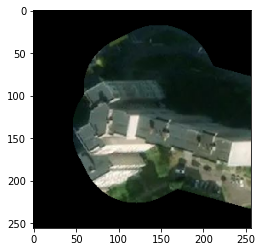

In [9]:
# Lets look at data we have
infer_dataset = InferDataset(dataset_files)
image, level, name = infer_dataset[random.randint(0, len(infer_dataset))] # get some sample
print(level)
print(name)
plt.imshow(image)
plt.show()

In [10]:
def preprocess_f(x):
    x = x.float()

    x.div_(255.0)

    x[:,0, :, :].add_(-0.485)
    x[:,1, :, :].add_(-0.456)
    x[:,2, :, :].add_(-0.406)

    x[:,0, :, :].div_(0.229)
    x[:,1, :, :].div_(0.224)
    x[:,2, :, :].div_(0.225)
    return x


def calc_euclidean(x1, x2):
    return (x1 - x2).pow(2).sum()


class AdaptivePoolingHead(nn.Sequential):
    def __init__(self, pooling="avg"):
        if pooling not in ("max", "avg"):
            raise ValueError("Pooling should be one of ('max', 'avg'), got {}.".format(pooling))
        pool = nn.AdaptiveAvgPool2d(1) if pooling == 'avg' else nn.AdaptiveMaxPool2d(1)
        super().__init__(pool)

class OsmNet(torch.nn.Module):
    def __init__(self, source_model, backbone_channels=512, num_classes=16):
        super(OsmNet, self).__init__()
        self.source_model = source_model
        # self.head = ClassificationHead(backbone_channels, 1)
        # self.head = RegressionHead(backbone_channels)

    def forward(self, x):
        x = x.float()
        x = preprocess_f(x)
        x = self.source_model.forward_features(x)
        # x = self.head(x)
        return x


net = OsmNet(timm.create_model('vgg11'))

In [11]:
CUDA = "cuda:0"
CPU = "cpu"
device = torch.device(CUDA) # if torch.cuda.is_available() else CPU)

In [12]:
net.load_state_dict(torch.load('./_best_vgg11.pth', map_location=CUDA))
net = net.to(device)

In [13]:
last_features = None
last_level = None
last_image = None

In [14]:
# Lets look at data we have
show_im = True
results = []

image, levels, name = infer_dataset[random.randint(0, len(infer_dataset))] # get some sample

features = None
with torch.no_grad():
    image_np = image
    image = torch.tensor(image.copy(), dtype=torch.float)
    image = torch.unsqueeze(image.to(device), 0)
    image = torch.transpose(image, 1, 3)
    features = net(image)

if last_features is not None:
    distance = float(calc_euclidean(features, last_features))
else:
    distance = None
    
if last_features is not None:
    print(distance)
    print(levels)
    plt.imshow(image_np)
    plt.show()
    
    print(last_level)
    plt.imshow(last_image)
    plt.show()
    
    
last_features = features
last_level = levels
last_image = image_np

In [15]:
# Lets look at data we have
output_path = work_path
features_prefix = 'f_'
features_ext = '.npy'

for n in trange(len(infer_dataset)-1):
    image, levels, name = infer_dataset[n] # get some sample
    with torch.no_grad():
        image_np = image
        image = torch.tensor(image.copy(), dtype=torch.float)
        image = torch.unsqueeze(image.to(device), 0)
        image = torch.transpose(image, 1, 3)
        features = net(image)
        features = features.detach().cpu().numpy()
        
        features_path = os.path.join(output_path, features_prefix + name + features_ext)
        with open(features_path, 'wb') as f:
            np.save(f, features)

100%|███████████████████████████████████████| 1653/1653 [01:43<00:00, 15.91it/s]
